<a href="https://colab.research.google.com/github/oluseyedev/oluseyedev/blob/main/data_analyses_news2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install dataset

#!pip install sentence-transformers
!pip install tensorflow

#!pip install --upgrade gensim







/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data Overview:
      id                                         image_link  \
0  13169  https://cdn-images.am-online.com:443/thumbs/32...   
1  13170  https://cdn-images.am-online.com:443/thumbs/32...   
2  13171  https://cdn-images.am-online.com:443/thumbs/32...   
3  13172  https://cdn-images.am-online.com:443/thumbs/32...   
4  13173  https://cdn-images.am-online.com:443/thumbs/32...   

                                           site_link  \
0  /news/cdk-global-reportedly-pays-25m-cyber-ran...   
1  /news/dealership-duo-dish-out-rough-justice-to...   
2  /news/lexus-slashes-ev-and-hybrid-prices-to-bo...   
3  /news/snows-aims-to-be-headline-event-at-new-m...   
4                           /news/new-ceo-at-bentley   

                                             heading  \
0  h4 classnewstitle mb2 CDK Global reportedly pa...   
1  h4 classnewstitle mb2 Dealership duo dish out ...   
2  h4 classnewstitle mb2 Lexus slashes EV and hyb...   
3  h4 classnewstitle mb2 Snows aims to be hea

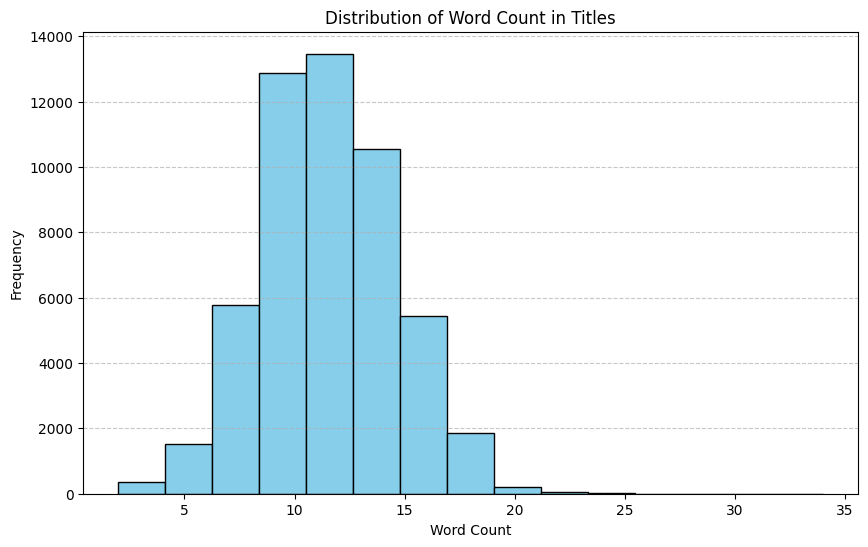


Processed Text Sample:
                                                 body  \
0  US software house CDK Global is reported to ha...   
1  A father and son who took the law into their o...   
2  Japanese luxury brand Lexus has significantly ...   
3  Southamptonbased Snows Motor Group will be sho...   
4  A host of industry movements announced this we...   

                                      processed_body  
0  us software house cdk global reported paid mil...  
1  father son took law hands assaulted man vandal...  
2  japanese luxury brand lexus significantly cut ...  
3  southamptonbased snows motor group showcasing ...  
4  host industry movements announced week include...  


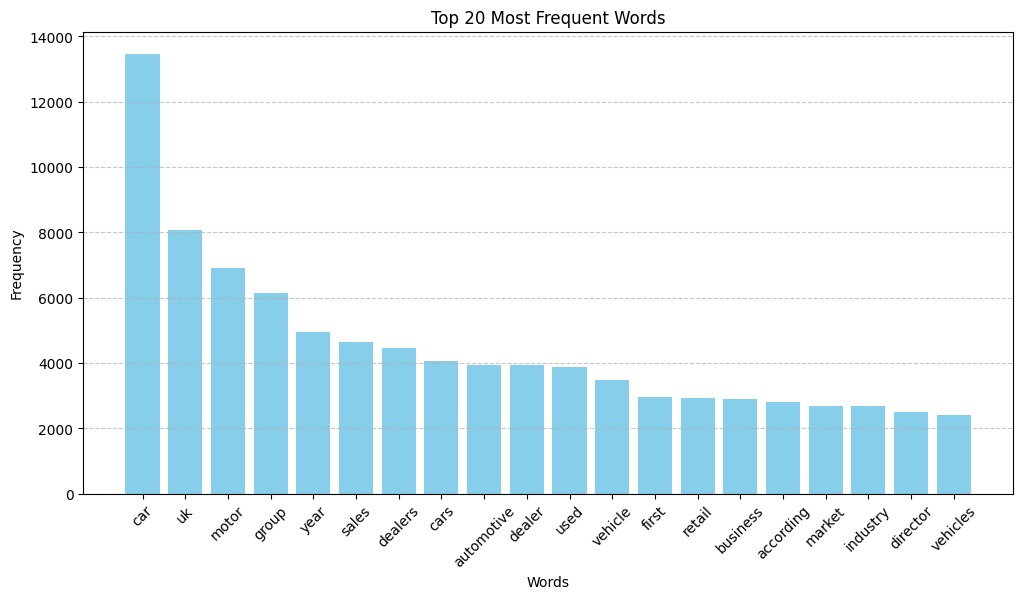

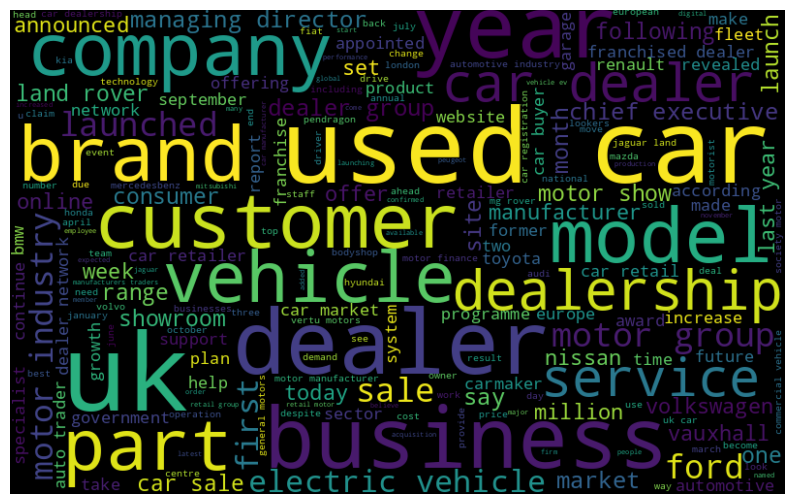

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from transformers import DistilBertTokenizer, DistilBertModel

# Ensure necessary NLTK data files downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load SpaCy English model
import spacy
nlp = spacy.load('en_core_web_sm')

# Load the dataset
data = pd.read_csv('/content/sample_data/Autmobile_extracted_news.csv')

# 1. Data Overview
print("Data Overview:")
print(data.head())
print(data.info())

# 2. Identify the missing values
missing_values = data.isnull().sum()
print("\nMissing Values:\n", missing_values)

# 3. Fix missing values
data['body'].fillna('', inplace=True)
data['image_link'].fillna('No image available', inplace=True)
missing_values = data.isnull().sum()
print("\nCheck for Missing Values after fix:\n", missing_values)

# 4. Analyze word count in titles
data['title_word_count'] = data['heading'].apply(lambda x: len(x.split()))
print("\nWord Count Summary:\n", data['title_word_count'].describe())

plt.figure(figsize=(10, 6))
plt.hist(data['title_word_count'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Count in Titles')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 5. Text Preprocessing
additional_stopwords = {'said', 'new', 'jim', 'well', 'would', 'could', 'should', 'might', 'must', 'shall',
                        'will', 'can', 'may', 'and', 'or', 'but', 'so', 'yet', 'for', 'nor', 'although',
                        'because', 'since', 'unless', 'until', 'while', 'however', 'therefore', 'moreover',
                        'thus', 'hence', 'consequently', 'nevertheless', 'nonetheless', 'similarly', 'likewise',
                        'thereafter', 'meanwhile', 'also', 'besides', 'furthermore', 'additionally', 'finally',
                        'firstly', 'secondly', 'thirdly', 'next', 'lastly', 'thereby', 'whereby', 'whereas'}

stop_words = set(stopwords.words('english')).union(additional_stopwords)

def preprocess_text_nltk(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['processed_body'] = data['body'].apply(preprocess_text_nltk)
print("\nProcessed Text Sample:\n", data[['body', 'processed_body']].head())

# 6. EDA - Most Frequent Words
all_processed_text = ' '.join(data['processed_body'])
word_freq = Counter(all_processed_text.split())
common_words = word_freq.most_common(20)

# Top 20 Most Frequent Words
words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualize most frequent words using WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_processed_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# 7. Text Similarity Measures

# Vectorizers
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['processed_body'])

# 1. Cosine Similarity with TF-IDF
cosine_sim_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 2. Cosine Similarity with Word Embeddings (Word2Vec)
sentences = [text.split() for text in data['processed_body']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word_embeddings = np.array([np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for words in sentences])

cosine_sim_word2vec = cosine_similarity(word_embeddings)

# 3. Cosine Similarity with Document Embeddings (Doc2Vec and SBERT)
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(sentences)]
doc2vec_model = Doc2Vec(tagged_data, vector_size=100, window=2, min_count=1, workers=4)
doc_embeddings = np.array([doc2vec_model.dv[str(i)] for i in range(len(tagged_data))])

cosine_sim_doc2vec = cosine_similarity(doc_embeddings)

# Using SBERT for document embeddings
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
sbert_embeddings = sbert_model.encode(data['processed_body'].tolist())

cosine_sim_sbert = cosine_similarity(sbert_embeddings)

# 4. Jaccard Similarity
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    union_len = len(s1.union(s2))
    if union_len == 0:
        return 0.0
    return float(len(s1.intersection(s2))) / union_len

jaccard_sim = np.zeros((len(data), len(data)))
for i in range(len(data)):
    for j in range(len(data)):
        jaccard_sim[i, j] = jaccard_similarity(data['processed_body'].iloc[i].split(), data['processed_body'].iloc[j].split())

# 5. Euclidean Distance on Latent Space (LSA)
lsa = TruncatedSVD(n_components=100)
lsa_matrix = lsa.fit_transform(tfidf_matrix)
euclidean_dist_lsa = euclidean_distances(lsa_matrix)

# 6. Word Overlap Similarity
def word_overlap(doc1, doc2):
    words_doc1 = set(doc1.split())
    words_doc2 = set(doc2.split())
    overlap = words_doc1.intersection(words_doc2)
    return len(overlap)

word_overlap_sim = np.zeros((len(data), len(data)))
for i in range(len(data)):
    for j in range(len(data)):
        word_overlap_sim[i, j] = word_overlap(data['processed_body'].iloc[i], data['processed_body'].iloc[j])

# Compare and visualize the best similarity models
similarity_scores = {
    'Cosine Similarity (TF-IDF)': cosine_sim_tfidf.mean(),
    'Cosine Similarity (Word2Vec)': cosine_sim_word2vec.mean(),
    'Cosine Similarity (Doc2Vec)': cosine_sim_doc2vec.mean(),
    'Cosine Similarity (SBERT)': cosine_sim_sbert.mean(),
    'Jaccard Similarity': jaccard_sim.mean(),
    'Euclidean Distance (LSA)': euclidean_dist_lsa.mean(),
    'Word Overlap Similarity': word_overlap_sim.mean()
}

# Sorting the similarity scores to find the best models
sorted_similarity = sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True)

# Visualization of the top two similarity models
best_two_models = [sorted_similarity[0][0], sorted_similarity[1][0]]
best_two_values = [sorted_similarity[0][1], sorted_similarity[1][1]]

plt.figure(figsize=(10, 5))
plt.bar(best_two_models, best_two_values, color=['dodgerblue', 'orange'])
plt.title('Top 2 Similarity Models')
plt.xlabel('Similarity Model')
plt.ylabel('Mean Similarity Score')
plt.show()

print (f"Best Similarity Models: {best_two_models[0]} and {best_two_models[1]}")

# 8. Categorization Models

# Define the categories based on keywords
categories = {
    'Vehicle Maintenance': ['maintenance', 'service'],
    'Auto Parts': ['parts', 'component'],
    'Technology and Innovation': ['technology', 'innovation'],
    'Industry News': ['industry', 'market'],
    'Training and Education': ['training', 'education'],
    'Electric Vehicles': ['electric', 'ev'],
    'Autonomous Vehicles': ['autonomous', 'self-driving'],
    'Recalls and Safety': ['recall', 'safety'],
    'Customer and Dealership Service': ['customer', 'dealership'],
    'Events and Trade Shows': ['event', 'show'],
    'Design and Engineering': ['design', 'engineering'],
    'Marketing and Sales': ['marketing', 'sales'],
    'Brands and Manufacturers': ['brand', 'manufacturer'],
    'Vehicle Performance and Tuning': ['performance', 'tuning']
}

# Function to categorize based on the presence of keywords
def categorize_article(text):
    for category, keywords in categories.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Unknown'

# Apply the categorization function
data['category'] = data['processed_body'].apply(categorize_article)

# Label encoding for the categories
label_encoder = LabelEncoder()
data['category_label'] = label_encoder.fit_transform(data['category'])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['processed_body'], data['category_label'], test_size=0.2, random_state=42)

# Vectorizing the text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize a dictionary to store the performance of each model
model_performance = {}

# 1. Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
y_pred_nb = nb_classifier.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
model_performance['Naive Bayes'] = nb_accuracy
print(f"Naive Bayes Classifier Accuracy: {nb_accuracy}")

# 2. K-Nearest Neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_tfidf, y_train)
y_pred_knn = knn_classifier.predict(X_test_tfidf)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
model_performance['K-Nearest Neighbors'] = knn_accuracy
print(f"K-Nearest Neighbors Classifier Accuracy: {knn_accuracy}")

# 3. Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_tfidf, y_train)
y_pred_dt = decision_tree.predict(X_test_tfidf)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
model_performance['Decision Tree'] = dt_accuracy
print(f"Decision Tree Classifier Accuracy: {dt_accuracy}")

# 4. Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_tfidf, y_train)
y_pred_rf = random_forest.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
model_performance['Random Forest'] = rf_accuracy
print(f"Random Forest Classifier Accuracy: {rf_accuracy}")

# 5. Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier(random_state=42)
gradient_boosting.fit(X_train_tfidf, y_train)
y_pred_gb = gradient_boosting.predict(X_test_tfidf)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
model_performance['Gradient Boosting'] = gb_accuracy
print(f"Gradient Boosting Classifier Accuracy: {gb_accuracy}")

# 6. Maximum Entropy Classifier (Logistic Regression)
max_entropy = LogisticRegression(random_state=42, max_iter=1000)
max_entropy.fit(X_train_tfidf, y_train)
y_pred_me = max_entropy.predict(X_test_tfidf)
me_accuracy = accuracy_score(y_test, y_pred_me)
model_performance['Maximum Entropy'] = me_accuracy
print(f"Maximum Entropy Classifier Accuracy: {me_accuracy}")

# Visualization of Model Performance
plt.figure(figsize=(12, 6))
plt.bar(model_performance.keys(), model_performance.values(), color='skyblue')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Deep Learning Models for Categorization

# Tokenizing and padding sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['processed_body'])
X_seq = tokenizer.texts_to_sequences(data['processed_body'])
X_padded = pad_sequences(X_seq, maxlen=200)

y_categorical = to_categorical(data['category_label'])

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        return x

# Parameters for LSTM model
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 128
hidden_dim = 128
output_dim = len(label_encoder.classes_)

# Instantiate and compile the LSTM model
lstm_model = LSTMModel(vocab_size, embed_dim, hidden_dim, output_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_dl, dtype=torch.long)
y_train_tensor = torch.tensor(np.argmax(y_train_dl, axis=1), dtype=torch.long)
X_test_tensor = torch.tensor(X_test_dl, dtype=torch.long)
y_test_tensor = torch.tensor(np.argmax(y_test_dl, axis=1), dtype=torch.long)

# Training the LSTM model
num_epochs = 5
batch_size = 64

for epoch in range(num_epochs):
    lstm_model.train()
    optimizer.zero_grad()
    outputs = lstm_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluate the LSTM model
lstm_model.eval()
with torch.no_grad():
    test_outputs = lstm_model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    lstm_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'LSTM Model Accuracy: {lstm_accuracy}')

# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        return x

# Instantiate and compile the RNN model
rnn_model = RNNModel(vocab_size, embed_dim, hidden_dim, output_dim)

# Training the RNN model
for epoch in range(num_epochs):
    rnn_model.train()
    optimizer.zero_grad()
    outputs = rnn_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluate the RNN model
rnn_model.eval()
with torch.no_grad():
    test_outputs = rnn_model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    rnn_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'RNN Model Accuracy: {rnn_accuracy}')



# Comparison and Visualization of Deep Learning Models
deep_learning_performance = {
    'LSTM': lstm_accuracy,
    'RNN': rnn_accuracy,
    }

plt.figure(figsize=(12, 6))
plt.bar(deep_learning_performance.keys(), deep_learning_performance.values(), color='salmon')
plt.title('Deep Learning Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Best two models for visualization
best_two_dl_models = sorted(deep_learning_performance.items(), key=lambda item: item[1], reverse=True)[:2]

# Visualization of article categorization for the best two deep learning models

# Get predictions and decode labels for visualization
def plot_categorization_results(model, X_test, y_test, model_name):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        predicted_categories = torch.argmax(predictions, axis=1)
        decoded_predictions = label_encoder.inverse_transform(predicted_categories.cpu().numpy())
        true_categories = label_encoder.inverse_transform(y_test.cpu().numpy())

        plt.figure(figsize=(12, 6))
        sns.countplot(x=decoded_predictions, order=np.unique(decoded_predictions), palette='cool')
        plt.title(f'{model_name} - Predicted Category Distribution')
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Plotting results for the best two deep learning models
for model_name, _ in best_two_dl_models:
    if model_name == 'LSTM':
        plot_categorization_results(lstm_model, X_test_tensor, y_test_tensor, 'LSTM Model')
    elif model_name == 'RNN':
        plot_categorization_results(rnn_model, X_test_tensor, y_test_tensor, 'RNN Model')


# DistilBERT Model for Categorization

# Load DistilBERT tokenizer and model
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Function to tokenize and encode using DistilBERT
def encode_articles(texts):
    inputs = distilbert_tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = distilbert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# Encode the articles using DistilBERT
X_train_distilbert = encode_articles(X_train.tolist())
X_test_distilbert = encode_articles(X_test.tolist())

# Define a simple neural network for classification
class DistilBERTClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DistilBERTClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc(x)
        x = self.softmax(x)
        return x

# Instantiate and compile the classifier
input_dim = X_train_distilbert.size(1)
output_dim = len(label_encoder.classes_)
distilbert_classifier = DistilBERTClassifier(input_dim, output_dim)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(distilbert_classifier.parameters(), lr=0.001)

# Convert DistilBERT embeddings to PyTorch tensors
X_train_tensor_distilbert = X_train_distilbert
y_train_tensor_distilbert = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor_distilbert = X_test_distilbert
y_test_tensor_distilbert = torch.tensor(y_test.values, dtype=torch.long)

# Training the DistilBERT-based model
num_epochs = 5
for epoch in range(num_epochs):
    distilbert_classifier.train()
    optimizer.zero_grad()
    outputs = distilbert_classifier(X_train_tensor_distilbert)
    loss = criterion(outputs, y_train_tensor_distilbert)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluate the DistilBERT-based model
distilbert_classifier.eval()
with torch.no_grad():
    test_outputs = distilbert_classifier(X_test_tensor_distilbert)
    test_loss = criterion(test_outputs, y_test_tensor_distilbert)
    _, predicted = torch.max(test_outputs, 1)
    distilbert_accuracy = (predicted == y_test_tensor_distilbert).sum().item() / len(y_test_tensor_distilbert)
    print(f'DistilBERT Classifier Accuracy: {distilbert_accuracy}')

# Compare DistilBERT with the Gradient Boosting Classifier
print(f'Gradient Boosting Classifier Accuracy: {gb_accuracy}')
print(f'DistilBERT Classifier Accuracy: {distilbert_accuracy}')
print(f'LSTM Model Accuracy: {lstm_accuracy}')




